# Localizing Particles using LodeSTAR

This notebook provides you with a complete code example that demonstrates how to train and use LodeSTAR to localize particles.

## Creating the Dataset

Define a particle located near the center of the image ...

In [1]:
import deeptrack as dt 
from numpy.random import uniform

image_size = 51

particle = dt.PointParticle(
    position=lambda: uniform(image_size / 2 - 5, image_size / 2 + 5, size=2),
)

... define the optical system as a fluorescence microscope ...

In [2]:
optics = dt.Fluorescence(output_region=(0, 0, image_size, image_size))

... create the  simulation pipeline ...

In [3]:
import torch

simulation = optics(particle) >> dt.NormalizeMinMax(0, 1) \
    >> dt.Gaussian(sigma=0.1) >> dt.MoveAxis(-1, 0) \
    >> dt.pytorch.ToTensor(dtype=torch.float32)

... create the train and test datasets ...

In [4]:
train_dataset = dt.pytorch.Dataset(simulation, length=100)
test_dataset = dt.pytorch.Dataset(simulation & particle.position, length=5000)

... and plot some generated particles and their position.

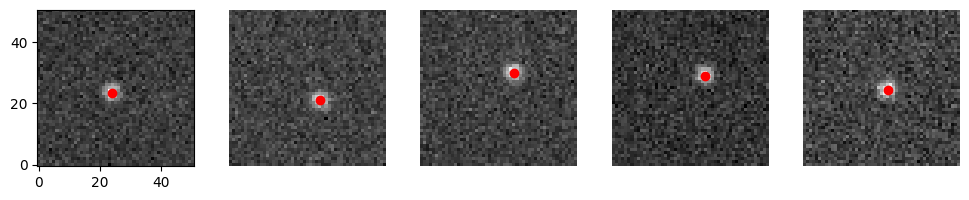

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 5, figsize=(10, 2))
for i, ax in enumerate(axs):
    image, position = test_dataset[i]
    ax.imshow(image[0], cmap="gray", origin="lower")
    ax.scatter(position[1], position[0], c="r")
    if i != 0: ax.axis("off")
plt.tight_layout()
plt.show()

## Learning from Translations

Implement a neural network with a convolutional backbone and a dense top layer ...

In [6]:
import deeplay as dl

backbone = dl.ConvolutionalNeuralNetwork(in_channels=1,
    hidden_channels=[16, 32, 64], out_channels=128, pool=torch.nn.MaxPool2d(2))
model = dl.Sequential(backbone, torch.nn.Flatten(), torch.nn.LazyLinear(2))

... implement a function to translate the input image ...

In [7]:
from kornia.geometry.transform import translate

def image_translation(batch, translation):
    """Translate a batch of images."""
    xy_flipped_translation = translation[:, [1, 0]]
    return translate(batch, xy_flipped_translation, padding_mode="reflection")

... a function to translate back the output positions ...

In [8]:
def inverse_translation(preds, applied_translation):
    """Invert translation of predicted positions."""
    return preds - applied_translation

... and a class to implement a self-supervised particle localizer trained with translations ...

In [9]:
from torch import rand

class ParticleLocalizer(dl.Application):
    """LodeSTAR implementation with translations."""
    
    def __init__(self, model, n_transforms=8, **kwargs):
        """Initialize the ParticleLocalizer."""
        self.model, self.n_transforms = model, n_transforms
        super().__init__(**kwargs)

    def forward(self, batch):
        """Forward pass through the model."""
        return self.model(batch)
    
    def random_arguments(self):
        """Generate random arguments for transformations."""
        return {"translation": \
            (rand(self.n_transforms, 2).float().to(self.device) * 5 - 2.5)}

    def forward_transform(self, batch, translation):
        """Apply forward translation to the image."""
        return image_translation(batch, translation)

    def inverse_transform(self, preds, translation):
        """Apply inverse translation to the predictions."""
        return inverse_translation(preds, translation)

    def training_step(self, image, batch_idx):
        """Perform a single training step."""
        image, *_ = image
        batch = image.repeat(self.n_transforms, 1, 1, 1)

        kwargs = self.random_arguments()
        transformed_batch = self.forward_transform(batch, **kwargs)

        pred_position = self(transformed_batch)
        pred_position = self.inverse_transform(pred_position, **kwargs)

        average_pred_position = pred_position \
            .mean(dim=0, keepdim=True).repeat(self.n_transforms, 1)

        loss = self.loss(pred_position, average_pred_position)
        self.log("loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

... intantiate this class ...

In [10]:
localizer = ParticleLocalizer(model, n_transforms=8, loss=torch.nn.L1Loss(),
                              optimizer=dl.Adam(lr=5e-4)).create()

... and train the self-supervised particle localizer trained with translations.

In [11]:
from torch.utils.data import DataLoader

dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
trainer = dl.Trainer(max_epochs=100)
trainer.fit(localizer, dataloader)

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:454: A lay

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model         │ Sequential       │ 97.2 K │
│ 1 │ loss          │ L1Loss           │      0 │
│ 2 │ train_metrics │ MetricCollection │      0 │
│ 3 │ val_metrics   │ MetricCollection │      0 │
│ 4 │ test_metrics  │ MetricCollection │      0 │
│ 5 │ optimizer     │ Adam             │      0 │
└───┴───────────────┴──────────────────┴────────┘

Trainable params: 97.2 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 97.2 K                                                                                               
Total estimated model params size (MB): 0

Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


### Evaluating the Performance

Evaluate the performance of the self-supervised particle localizer trained with translations ...

In [12]:
images, positions = zip(*test_dataset)
images, positions = torch.stack(images), torch.stack(positions)

predictions = localizer(images).detach().numpy()

... implement a function to plot the predicted positions versus the real ones ...

In [13]:
def plot_position_comparison(positions, predictions):
    """Plot comparison between predicted and real particle positions."""
    plt.figure(figsize=(14, 8))
    grid = plt.GridSpec(4, 7, wspace=.2, hspace=.1)

    plt.subplot(grid[1:, :3])
    plt.scatter(positions[:, 0], predictions[:, 0], alpha=.5) 
    plt.axline((25, 25), slope=1, color="black")
    plt.xlabel("True Horizontal Position", fontsize=20)
    plt.ylabel("Predicted Horizontal Position", fontsize=20)
    plt.axis("equal")    

    plt.subplot(grid[1:, 4:])
    plt.scatter(positions[:, 1], predictions[:, 1], alpha=.5)
    plt.axline((25, 25), slope=1, color="black")
    plt.xlabel("True Vertical Position", fontsize=20)
    plt.ylabel("Predicted Vertical Position", fontsize=20)
    plt.axis("equal")

    plt.show()

... and use it to plot the predicted versus real positions.

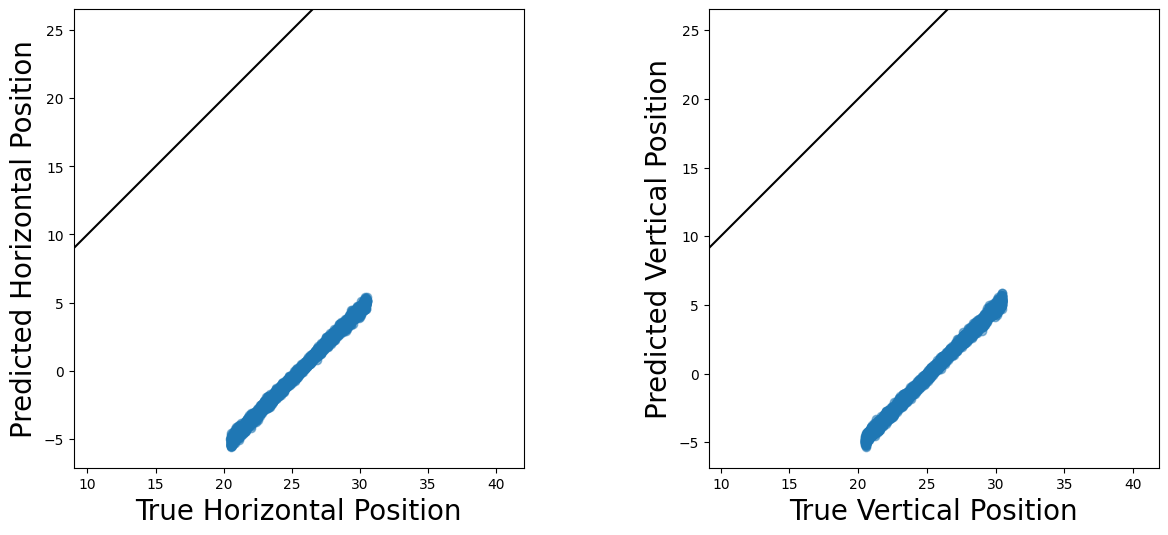

In [14]:
plot_position_comparison(positions, predictions)

## Improving the Predictions Averaging Reflected Images

Correct the bias of a self-supervised particle localizer trained with translations.

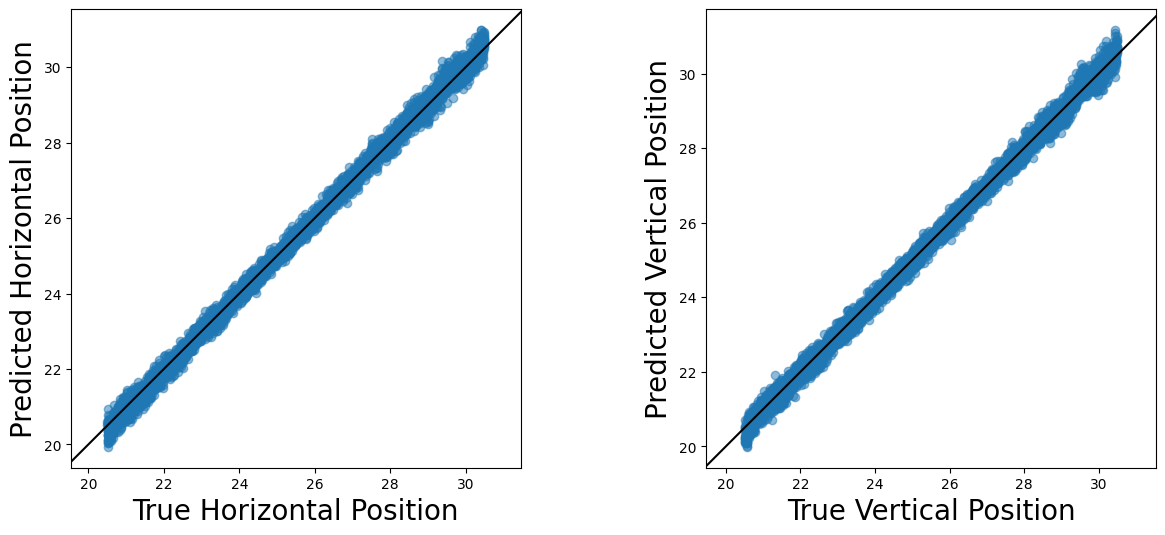

In [15]:
direct_preds = localizer(images).detach().numpy()

flipped_images = images.flip(dims=(2, 3))
flipped_preds = localizer(flipped_images).detach().numpy()

predictions_with_difference = ((direct_preds - flipped_preds) / 2 
                               + image_size / 2 - 0.5)

plot_position_comparison(positions, predictions_with_difference)

## Learning from Reflections

Implement a function to conditionally reflect images along a specified dimension ...

In [16]:
def flip_transform(batch, should_flip, dim):
    """Conditionally flip batch along a specified dimension."""
    should_flip = should_flip.view(-1, 1, 1, 1)
    return torch.where(should_flip, batch.flip(dims=(dim,)), batch)

... a function to conditionally inverse flip images ...

In [17]:
def inverse_flip_transform(preds, should_flip, dim):
    """Conditionally inverse flip transformation based on should_flip."""
    should_flip_mask = torch.zeros_like(preds).bool()
    should_flip_mask[should_flip, dim] = 1
    return torch.where(should_flip_mask, -preds, preds)

... and a class to implement a self-supervised particle localizer trained also with reflections (flips) ...

In [18]:
class ParticleLocalizerWithFlips(ParticleLocalizer):
    """ParticleLocalizer with additional flips."""
    
    def forward_transform(self, batch, translation, flip_x, flip_y):
        """Apply forward translations and flips to the batch."""
        batch = image_translation(batch, translation)
        batch = flip_transform(batch, flip_x, dim=3)
        batch = flip_transform(batch, flip_y, dim=2)
        return batch
    
    def inverse_transform(self, preds, translation, flip_x, flip_y):
        """Apply the inverse transformations to the predictions."""
        preds = inverse_flip_transform(preds, flip_x, dim=1)
        preds = inverse_flip_transform(preds, flip_y, dim=0)
        preds = inverse_translation(preds, translation)
        return preds
    
    def random_arguments(self):
        """Generate random arguments for translation and flips."""    
        return {"translation": \
            (rand(self.n_transforms, 2).float().to(self.device) * 5 - 2.5),
            "flip_x": rand(self.n_transforms).float().to(self.device) > 0.5,
            "flip_y": rand(self.n_transforms).float().to(self.device) > 0.5}

... train a self-supervised particle localizer with flipping transformations ...

In [19]:
localizer_with_flips = ParticleLocalizerWithFlips(
    model, n_transforms=8, loss=torch.nn.L1Loss(), optimizer=dl.Adam(lr=1e-3)
).create()

trainer_with_flips = dl.Trainer(max_epochs=100)
trainer_with_flips.fit(localizer_with_flips, dataloader)

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model         │ Sequential       │ 97.2 K │
│ 1 │ loss          │ L1Loss           │      0 │
│ 2 │ train_metrics │ MetricCollection │      0 │
│ 3 │ val_metrics   │ MetricCollection │      0 │
│ 4 │ test_metrics  │ MetricCollection │      0 │
│ 5 │ optimizer     │ Adam             │      0 │
└───┴───────────────┴──────────────────┴────────┘

Trainable params: 97.2 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 97.2 K                                                                                               
Total estimated model params size (MB): 0

Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


... and plot the predictions versus real positions for a self-supervised particle localizer with reflections.

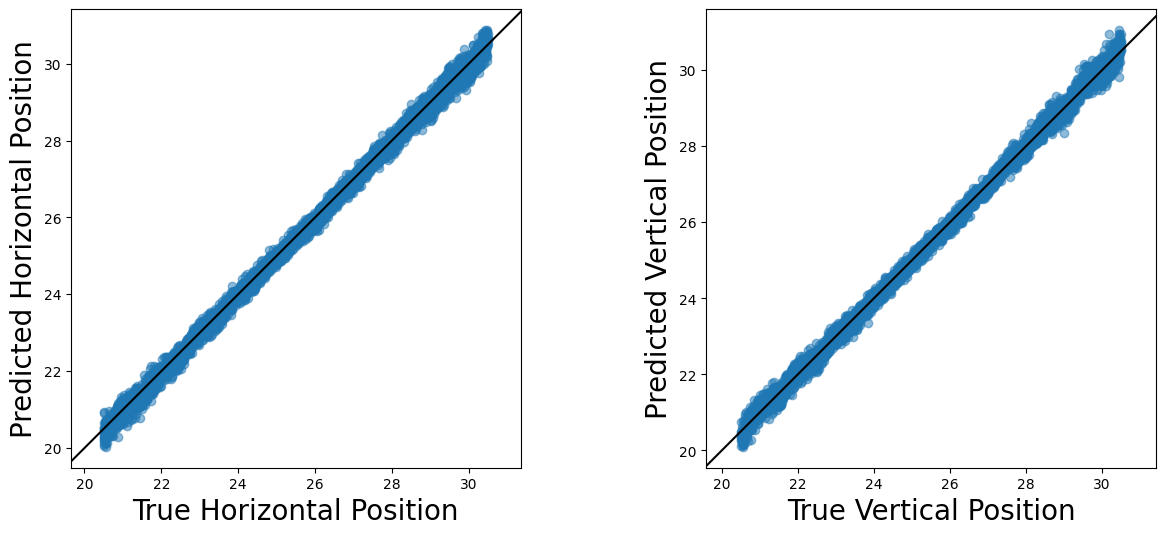

In [20]:
predictions = (localizer_with_flips(images).detach().numpy() 
               + image_size / 2 - 0.5)

plot_position_comparison(positions, predictions)

## Improving Performance with LodeSTAR

Train LodeSTAR ...

In [21]:
dataloader_lodestar = DataLoader(train_dataset, batch_size=4, shuffle=True)

lodestar = dl.LodeSTAR(optimizer=dl.Adam(lr=1e-4)).build()

trainer_lodestar = dl.Trainer(max_epochs=100)
trainer_lodestar.fit(lodestar, dataloader_lodestar)

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type                       ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model         │ ConvolutionalNeuralNetwork │  251 K │
│ 1 │ between_loss  │ L1Loss                     │      0 │
│ 2 │ within_loss   │ L1Loss                     │      0 │
│ 3 │ train_metrics │ MetricCollection           │      0 │
│ 4 │ val_metrics   │ MetricCollection           │      0 │
│ 5 │ test_metrics  │ MetricCollection           │      0 │
│ 6 │ optimizer     │ Adam                       │      0 │
└───┴───────────────┴────────────────────────────┴────────┘

Trainable params: 251 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 251 K                                                                                                
Total estimated model params size (MB): 1

Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.
/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


... and plot its performance.

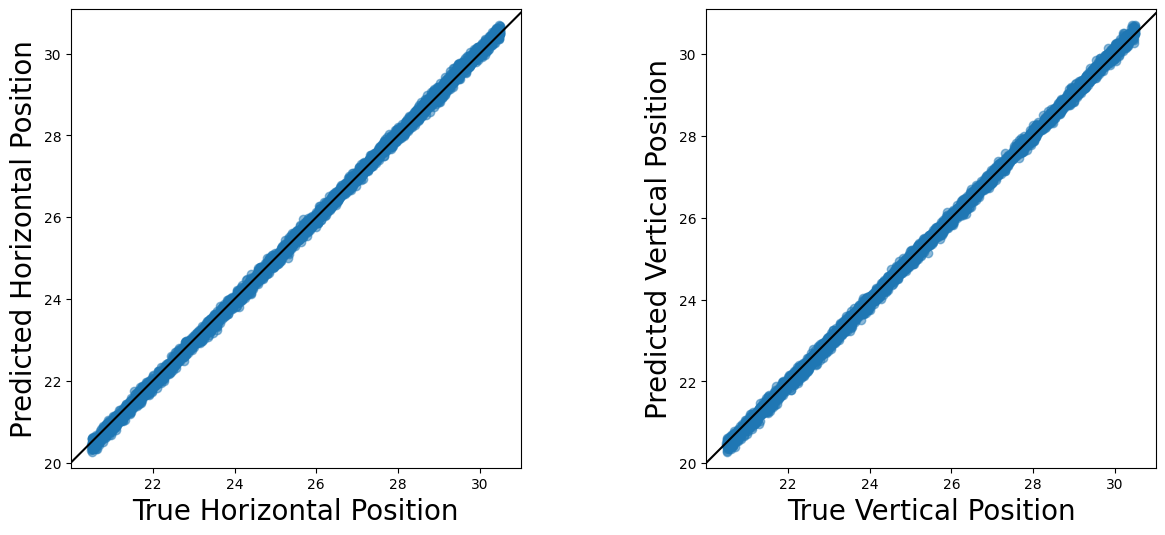

In [22]:
lodestar_predictions = lodestar.pooled(images).detach().numpy() 

plot_position_comparison(positions, lodestar_predictions)